# Quadratic RF Spoiling bSSFP #

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.optimize import curve_fit

In [2]:
# FUNCTIONS
#RF pulse excitation matrix
def RF_pulse(alpha, phi):
    #The RF pulse tip the spin "alpha" degree from z axis
    #and a phase shift of "phi" degree clockwise from x axis
    
    #convert in to radians 
    a = math.radians(alpha)
    p = math.radians(phi)
    #each term of the matrix
    r11 = math.cos(a)*math.sin(p)**2 + math.cos(p)**2
    r12 = (1 - math.cos(a))*math.cos(p)*math.sin(p)
    r13 = - math.sin(a)*math.sin(p)
    r21 = (1 - math.cos(a))*math.cos(p)*math.sin(p)
    r22 = math.cos(a)*math.cos(p)**2 + math.sin(p)**2
    r23 = math.sin(a)*math.cos(p)
    r31 = math.sin(a)*math.sin(p)
    r32 = - math.sin(a)*math.cos(p)
    r33 = math.cos(a)
    R = np.asarray([[r11,r12,r13],[r21,r22,r23],[r31,r32,r33]], dtype = float)
    
    return R

#T1 recovery, T2 decay terms effect for time t
def Relaxation(t, T1, T2):
    e2 = np.exp(-t/T2)
    e1 = np.exp(-t/T1)
    E = np.asarray([[e2 , 0, 0],[0, e2, 0],[0, 0, e1]], dtype = float)
    
    return E

#Precession term effect on off-resonance (f_off Hz) spin at time t
def Precession(f_off, t):
    #free-precession angle beta
    b = f_off*t*2*math.pi
    #rad
    #b = math.radians(beta)
    P = np.asarray([[math.cos(b), math.sin(b), 0],[-math.sin(b), math.cos(b), 0],[0, 0, 1]], dtype = float)
    
    return P

#Calculate the phase shift for current TR (quadratic spoiling)
def QuadraticPhase(N, n):
    n = n%N
    phi_quad = 360/N
    phase = phi_quad*n*n/2
 
    #in degree
    return phase


    

<p>Parameters T1, T2, TR, TE, tip angle, period, initial magnetisation. <p/>
<p>phase $\phi_n =\frac{n^2 \times \phi_{quad}}{2} $ <p/>

# quadatic RF spoiling bSSFP data simulation function #


In [3]:
#return 
#transverse steady state magnitude at different off-resonance frequency (column) and when acquire at different TR (row)
#corresponding off-resonance frequency


def bSSFPSimulation(T1, T2, off_res_max, TR, TE, tip_angle, Period, M0, dataAcquire, TRnum):
    #store value
    off_resonance_f = np.asarray([], dtype = int)
    M_complex_steady_all = np.asarray(np.zeros((dataAcquire,1)), dtype = float)


    #Find steady state value for different off-resonance 
    #f_off = 200 is next period, so here we only use -200~199
    for f_off in range(-off_res_max,off_res_max,1):
        M_pre = M0 #initial pre pulse magnetisation 

        #store complex transverse magnitude at different TRs
        M_complex_steady = np.asarray([], dtype = float)
        #store all complex transverse magnitude 
        M_complex = np.asarray([], dtype = float)
        phase_shift = 0
        Period_num = 0



        #repeat 1000 times for each off-resonance frequency
        for k in range(1,TRnum):
            #Calculate phase shift (degree) for this TR
            phase_shift = QuadraticPhase(Period, Period_num)
            #Tip
            M_post = RF_pulse(tip_angle,phase_shift) @ M_pre

            #Consider T1 recovery, T2 decay and precession
            #@ time TE 
            P_TE = Precession(f_off,TE) #precession matrix at t = TE
            E_TE = Relaxation(TE, T1, T2) #Relaxation matrix at t = TE

            M_TE = P_TE @ E_TE @ M_post + (np.identity(3) - E_TE) @ M0 #magnetisation at TE
            

            #@ time TR 
            P_TR = Precession(f_off,TR) #precession matrix at t = TR
            E_TR = Relaxation(TR, T1, T2) #Relaxation matrix at t = TR
            M_TR = P_TR @ E_TR @ M_post + (np.identity(3) - E_TR) @ M0 #magnetisation at TR
            #Gaussian noise added
            M_pre = M_TR 

            #store the transverse magnetisation in complex form, Mx+iMy
            M_complex = np.append(M_complex, complex(M_TE[0],M_TE[1]))

            Period_num = Period_num + 1     
        #END
        #take the final steady signal, store the transverse steady state signal for different off-resonance frequency
        for state in range (1,dataAcquire+1):
            M_complex_steady = np.append(M_complex_steady, M_complex[-state])
        M_complex_steady = np.reshape(M_complex_steady,(dataAcquire,1))
        M_complex_steady_all = np.append(M_complex_steady_all, M_complex_steady, axis = 1)
        off_resonance_f = np.append(off_resonance_f, f_off)
    #END
    M_complex_steady_all = np.delete(M_complex_steady_all,0,1)
    
    return M_complex_steady_all, off_resonance_f


# Simulation

In [4]:
# the parameters used in this simulation 
#time unit --- second
proton_density = 1.0
T1 = 900e-3
T2 = 44e-3
TR = 2.5e-3 
TE = TR/2
# tip angle alpha 10, 30, 90 degree
tip_angle = 10
#phase cycling
Period = 8
#initial magnetisation 
M0 = np.asarray([[0],[0],[1]],dtype = float)

off_res_max = 400
#Rep_num = off_res_max*2/(1/TR)
dataAcquire = 1
TRnum = 500


#T2* range 13 ms to 53 ms
T2s_max = 53
T2s_min = 13
T2p = np.asarray([], dtype = float)
for i in range (13, 54):
    if (i != (T2*1000)):
        T2p = np.append(T2p, 1/((1000/i)-1/T2))

In [5]:
M_transverse, off_resonance_f = bSSFPSimulation(T1, T2, off_res_max, TR, TE, tip_angle, Period, M0, dataAcquire, TRnum)


Text(0, 0.5, '$S_F$')

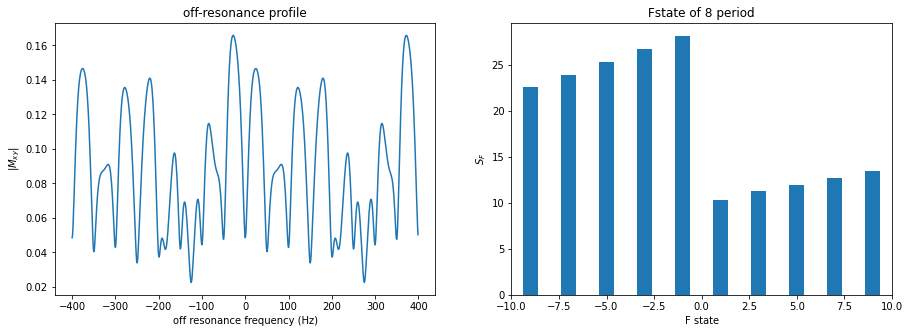

In [8]:
#Fourier transform of the off-resonance profile --> contribution from each F-state
S_F = np.fft.fft(M_transverse)
S_F = np.absolute(S_F)
S_F = np.fft.fftshift(S_F)

F_state = np.fft.fftfreq(M_transverse.shape[-1], d = 1.0)
F_state = np.fft.fftshift(F_state)*M_transverse.shape[-1]


fig, axs  = plt.subplots(dataAcquire,2,figsize=(15, 5))
axs[0].set_title("off-resonance profile")
axs[1].set_title("Fstate of " + str(Period)+ " period")

axs[0].plot(off_resonance_f, np.absolute(M_transverse[0,:]))
axs[0].set_xlabel("off resonance frequency (Hz)")
axs[0].set_ylabel("$|M_{xy}|$")



axs[1].bar(F_state, S_F[0,:])
axs[1].set_xlim([-10,10])
axs[1].set_xlabel("F state")
axs[1].set_ylabel("$S_F$")
#plt.savefig(".\OffresProfileANDFstateProfile_" +"period4_TRnum500.jpg") 

## 

# Show fitting method 


T2* Ground Truth: 0.013000000000000001
T2* Measured: 0.013096538873510954

T2* Ground Truth: 0.014
T2* Measured: 0.014106916601154217

T2* Ground Truth: 0.015
T2* Measured: 0.015117796945490475

T2* Ground Truth: 0.016
T2* Measured: 0.01612918022112207

T2* Ground Truth: 0.016999999999999998
T2* Measured: 0.01714106651859913

T2* Ground Truth: 0.018
T2* Measured: 0.01815345584247908

T2* Ground Truth: 0.019
T2* Measured: 0.01916634823074167

T2* Ground Truth: 0.02
T2* Measured: 0.02017974356973992

T2* Ground Truth: 0.020999999999999998
T2* Measured: 0.021193642010930883

T2* Ground Truth: 0.022000000000000002
T2* Measured: 0.0222080435295187

T2* Ground Truth: 0.023
T2* Measured: 0.023222948248387634

T2* Ground Truth: 0.024
T2* Measured: 0.02423835617423735

T2* Ground Truth: 0.025
T2* Measured: 0.02525426763945825

T2* Ground Truth: 0.026000000000000002
T2* Measured: 0.02627068279580777

T2* Ground Truth: 0.027
T2* Measured: 0.027287601701480934

T2* Ground Truth: 0.028
T2* Measure

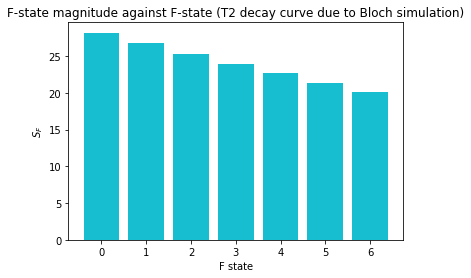

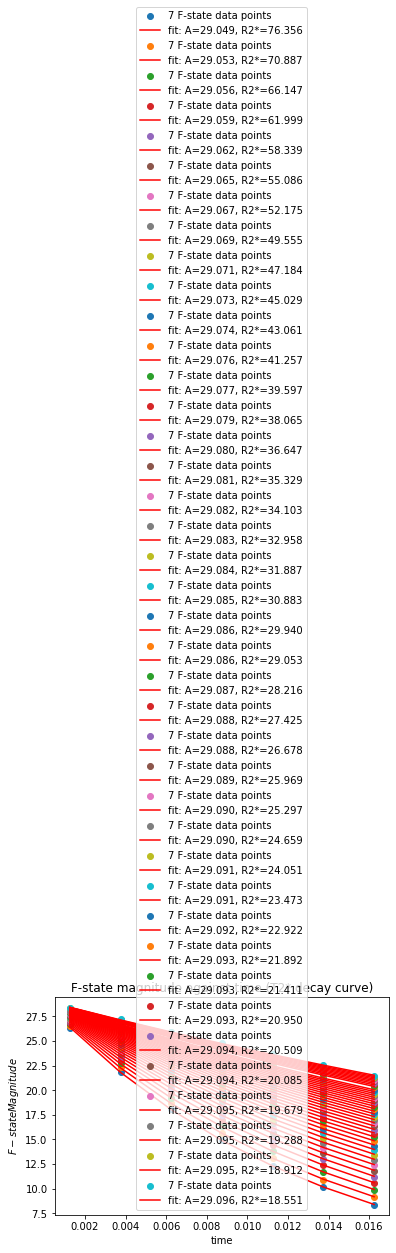

In [10]:
S_F_1 = S_F[0,:]
T2_inhom = 18e-3
for T2_inhom in T2p:
    #-----------------Calculate Ground Truth T2*---------------------------------------------------
    T2Star_GT = 1/((1/T2)+(1/T2_inhom))

    #-----------------Calculate the T2* from simulation data (measured T2*)------------------------
    #recorded 6 F-states (due to the use of Bloch simulation, these F-states magnitude can only fit a T2 decay curve)
    F_t2 = np.asarray([], dtype = float)
    F_t2_statenum = np.asarray([], dtype = float)
    F_state = np.round(F_state).astype(int) #round F-state all to integer 

    for i in range (0,7):
        F_index = np.where(F_state == float(-1-2*i))

        F_t2_statenum = np.append(F_t2_statenum, i)
        F_t2 = np.append(F_t2, S_F_1[F_index])
        # print('F-state:'+ str(i) +' S_F:'+ str(S_F[F_index]))

    #transfer F-states (T2 related) to F-states (T2* related)
    F_t2star = np.asarray([], dtype = float)
    time = np.asarray([], dtype = float)
    ## time = TE+F*TR
    time = TE*np.ones(np.shape(F_t2_statenum))+ F_t2_statenum *TR
    F_t2star = F_t2 *np.exp(-time/T2_inhom)

    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
    #exponential curve fitting to find T2* value
    def func(t, A, R2Star):
        return A * np.exp(-R2Star * t)
    #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
    popt, pcov = curve_fit(func, time, F_t2star)
    T2Star_measured = 1/popt[1]


    #--------------Plots----------------------------------------------------------------------------
    plt.figure(1)
    plt.title("F-state magnitude against F-state (T2 decay curve due to Bloch simulation)")
    plt.bar(F_t2_statenum, F_t2)
    plt.xlabel("F state")
    plt.ylabel("$S_F$")
    plt.savefig(".\Figure\FstateOf" + str(Period)+"_period.jpg")

    plt.figure(2)
    plt.title("F-state magnitude against time (T2* decay curve)")
    plt.scatter(time, F_t2star, label = '7 F-state data points')
    plt.plot(time, func(time, *popt),'r-', label='fit: A=%5.3f, R2*=%5.3f' % tuple(popt))
    plt.xlabel("time")
    plt.ylabel("$F-state Magnitude$")
    plt.legend()
    plt.savefig(".\Figure\T2Starfit" + str(Period)+"_period.jpg")
    print('\nT2* Ground Truth: '+str(T2Star_GT) +'\nT2* Measured: '+ str(T2Star_measured))